# Assignment 9: Introspection

### Assignment question is available here: https://ovgu-ailab.github.io/idl2023/assignment9.html

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

170498071/170498071 [==============================] - 6s 0us/step
6


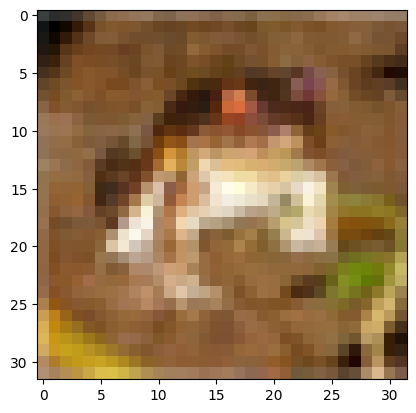

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# CIFAR labels for some reason are [N, 1] instead of just [N,] so we reshape them
train_labels = train_labels.reshape(-1).astype(np.int32)
test_labels = test_labels.reshape(-1).astype(np.int32)

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

print(train_labels[0])
plt.imshow(train_images[0])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
train_data = train_data.shuffle(buffer_size=60000).batch(128)

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)).batch(128)

In [3]:
# here's an example for a better definition.
# I also included 1x1 convolutions as in the actual inception architecture.
def inception_block(inputs, n_filters):
    conv1_1 = tf.keras.layers.Conv2D(n_filters, 1, activation=tf.nn.relu, padding="same")(inputs)

    conv1_3 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_3 = tf.keras.layers.Conv2D(n_filters, 3, activation=tf.nn.relu, padding="same")(conv1_3)

    conv1_5 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_5 = tf.keras.layers.Conv2D(n_filters, 5, activation=tf.nn.relu, padding="same")(conv1_5)

    pool1 = tf.keras.layers.MaxPool2D(3, 1, padding="same")(inputs)
    pool1 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(pool1)

    concat1 = tf.concat([conv1_1, conv1_3, conv1_5, pool1], axis=-1)

    return concat1


# it's easy to build a deeper model that way.
inputs = tf.keras.layers.Input((32, 32, 3))

blocks_per_resolution = 2
filters = [32, 64, 128]

x = inputs
for n_filters in filters:
    for block in range(blocks_per_resolution):
        x = inception_block(x, n_filters)
    # downsample
    x = tf.keras.layers.MaxPool2D(padding="same")(x)

pooled = tf.keras.layers.GlobalAveragePooling2D()(x)
logits = tf.keras.layers.Dense(10)(pooled)

model = tf.keras.Model(inputs, logits, name="inception")

print(model.summary())

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 32)           128       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 32)           128       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 3)            0         ['input_1[0][0]']             
 D)                                                                                       

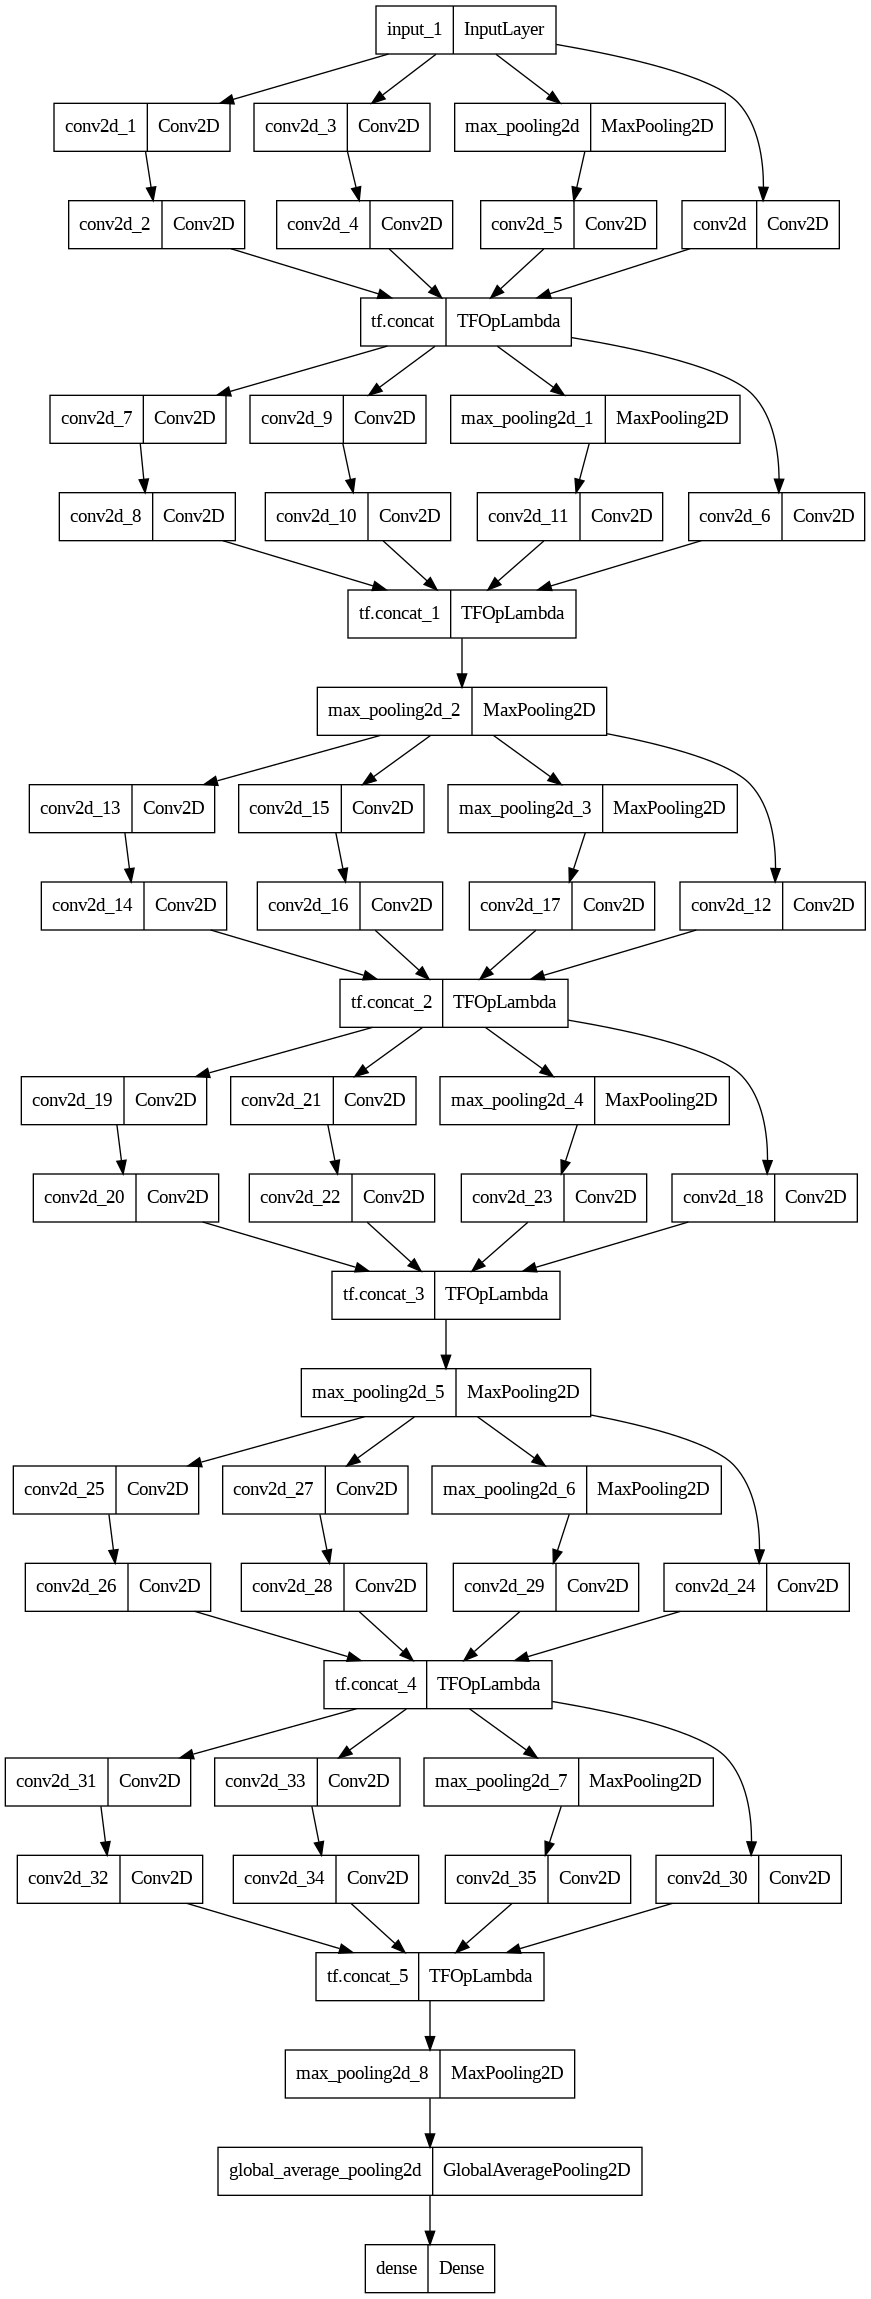

In [4]:
tf.keras.utils.plot_model(model)

In [5]:
optimizer = tf.optimizers.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = tf.metrics.SparseCategoricalAccuracy()

# jit_compile can give a significant speed-up and improves memory usage
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric],
              jit_compile=True)

In [6]:
model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
391/391 [==============================] - 46s 60ms/step - loss: 1.5938 - sparse_categorical_accuracy: 0.4134 - val_loss: 1.2365 - val_sparse_categorical_accuracy: 0.5479
Epoch 2/10
391/391 [==============================] - 12s 31ms/step - loss: 1.0188 - sparse_categorical_accuracy: 0.6381 - val_loss: 0.9115 - val_sparse_categorical_accuracy: 0.6755
Epoch 3/10
391/391 [==============================] - 12s 31ms/step - loss: 0.7624 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.6947 - val_sparse_categorical_accuracy: 0.7596
Epoch 4/10
391/391 [==============================] - 12s 31ms/step - loss: 0.6037 - sparse_categorical_accuracy: 0.7871 - val_loss: 0.6305 - val_sparse_categorical_accuracy: 0.7868
Epoch 5/10
391/391 [==============================] - 12s 31ms/step - loss: 0.5137 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.5625 - val_sparse_categorical_accuracy: 0.8092
Epoch 6/10
391/391 [==============================] - 12s 31ms/step - loss: 0.4268 - spars

In [7]:
# evaluate test loss and metrics
model.evaluate(test_data)

79/79 [==============================] - 1s 10ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.8297


[0.5635367035865784, 0.8296999931335449]

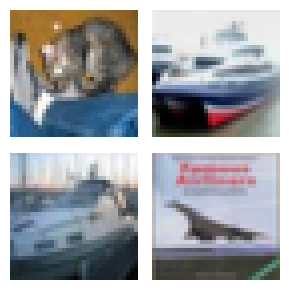

In [8]:
# FOLLOWING ARE THE SALIENCY MAPS


# just plot some example images
some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(3, 3))
for ind, img in enumerate(some_imgs):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# as discussed in the class: mask out logits to keep only the ones we need!
# here: using the true labels
model(some_imgs) * tf.one_hot(test_labels.reshape(-1)[:4], depth=10)

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[-0.      ,  0.      , -0.      ,  5.025946, -0.      ,  0.      ,
         0.      , -0.      , -0.      , -0.      ],
       [ 0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ,
        -0.      , -0.      , 11.954114,  0.      ],
       [ 0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ,
        -0.      , -0.      ,  6.615887,  0.      ],
       [ 6.322065, -0.      ,  0.      , -0.      , -0.      , -0.      ,
        -0.      , -0.      ,  0.      , -0.      ]], dtype=float32)>

In [10]:
# could also be using predictions, e.g.
tf.argmax(model(some_imgs), axis=-1)  # then turn to one-hot

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5, 8, 8, 0])>

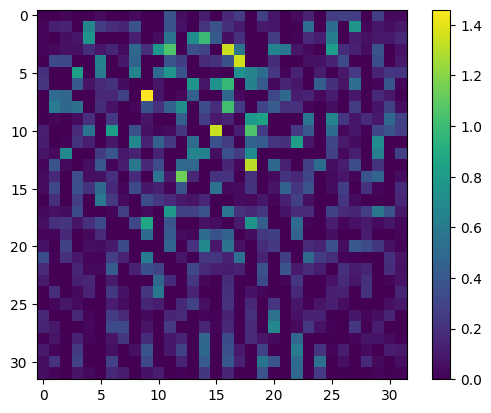

In [11]:
# basic saliency maps!

with tf.GradientTape() as tape:
    tape.watch(some_imgs)
    some_labels = tf.one_hot(test_labels[:4], depth=10)
    logits = model(some_imgs) * some_labels

grads = tape.gradient(logits, some_imgs).numpy()

# in practice, we often just care about positive contributions, so we remove negative values
grads_clip = np.where(grads >= 0, grads, 0)

# if we have multi-channel images, average channels
# no need to do this if you have e.g. MNIST as data
grads_mean = grads_clip.mean(axis=-1)

plt.imshow(grads_mean[0])
plt.colorbar()

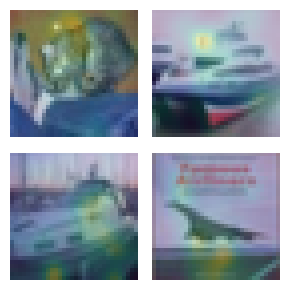

In [12]:

import scipy.ndimage

some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(3, 3))
for ind, (img, grad) in enumerate(zip(some_imgs, grads)):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    grad_clip = np.where(grad>0, grad, 0).mean(axis=-1)
    # in addition, slightly blur gradients to reduce noise
    grad_clip = scipy.ndimage.gaussian_filter(grad_clip, 2)

    plt.imshow(grad_clip, alpha=0.3)
    plt.axis("off")
    #plt.colorbar()
plt.tight_layout()
plt.show()

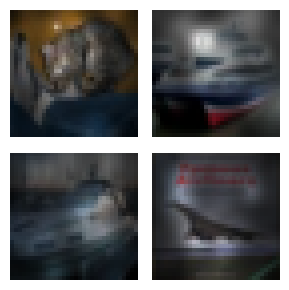

In [13]:
some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(3, 3))
for ind, (img, grad) in enumerate(zip(some_imgs, grads)):
    plt.subplot(2, 2, ind + 1)
    #plt.imshow(img)
    grad_clip = np.where(grad>0, grad, 0)
    grad_clip = grad_clip.mean(axis=-1, keepdims=True)
    grad_clip = scipy.ndimage.gaussian_filter(grad_clip, 2)

    # silly alternative idea: normalize gradients to [0, 1]
    # then multiply with images -> "lights up" important regions
    grad_clip /= grad_clip.max()
    img_scaled = grad_clip * img
    plt.imshow(img_scaled)

    plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
# to do activation maximization:

# - choose some target activation (could be logits for a certain class, or activations of a certain hidden neuron, or...)
# - start from a *random* image
# - compute gradients aka saliency maps, NO post-processing
# - add gradients*learning_rate to the image
# - repeat for many steps -> gradient ascent to create an image that maximally activates the network
#   - after every step, should clip images to [0, 1], since gradient descent doesn't know it should stay in that boundary
# - in practice, needs regularization to look good (check e.g. distill article)

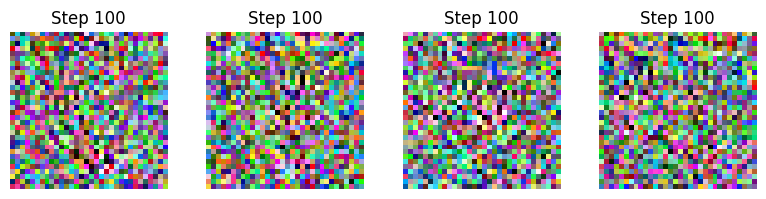

In [15]:
# Activation Maximization

def generate_activation_maximization_image(model, target_class, num_steps, learning_rate=0.01):
    # Start from a random image
    generated_image = tf.random.uniform((1, 32, 32, 3), minval=0, maxval=1)

    for step in range(num_steps):
        with tf.GradientTape() as tape:
            # Watch the generated image
            tape.watch(generated_image)

            # Compute the logits for the target class
            logits = model(generated_image)
            target_logits = logits[0, target_class]

        # Compute the gradient of the target class logit with respect to the input image
        gradients = tape.gradient(target_logits, generated_image)

        # Update the image using gradient ascent
        generated_image = generated_image + learning_rate * gradients

        # Clip the image to [0, 1]
        generated_image = tf.clip_by_value(generated_image, 0, 1)

    return generated_image

# Choose a target class (e.g., class 3)
target_class = 3

# Number of steps for gradient ascent
num_steps = 100

# Generate activation maximization images for the target class
activation_max_images = []
for _ in range(4):  # Generate 4 activation maximization images
    activation_max_image = generate_activation_maximization_image(model, target_class, num_steps)
    activation_max_images.append(activation_max_image.numpy())

# Plot activation maximization images
plt.figure(figsize=(8, 2))
for ind, img in enumerate(activation_max_images):
    plt.subplot(1, 4, ind + 1)
    plt.imshow(img[0])
    plt.title(f'Step {num_steps}')
    plt.axis("off")
plt.tight_layout()
plt.show()


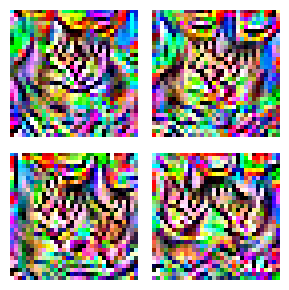

In [17]:
# Activation Maximization

def generate_image_from_gradients(model, target_class, image_size=(32, 32, 3), steps=100, learning_rate=0.1):
    # Initialize a random image
    generated_image = tf.random.uniform(shape=(1,) + image_size, minval=0, maxval=1)

    for step in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(generated_image)

            # Compute the activation of the target class
            target_activation = model(generated_image)[:, target_class]

        # Compute the gradient of the target activation with respect to the image
        gradient = tape.gradient(target_activation, generated_image)

        # Update the generated image using gradient ascent
        generated_image += learning_rate * gradient

        # Clip the image to [0, 1] to prevent out-of-bounds values
        generated_image = tf.clip_by_value(generated_image, 0, 1)

    return generated_image.numpy()

# Choose a target class (e.g., class 3)
target_class = 3

# Generate images that maximize the activation of the chosen class
generated_images = []
for i in range(4):
    generated_img = generate_image_from_gradients(model, target_class)
    generated_images.append(generated_img.squeeze())

# Plot the generated images
plt.figure(figsize=(3, 3))
for ind, img in enumerate(generated_images):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()


### Saliency maps can be especially interesting for wrongly classified inputs. Here, you could compute saliency maps for either the correct class, or the predicted one. How do the two differ?

Saliency maps computed for wrongly classified inputs can provide insights into why the model made an incorrect prediction. You can compute saliency maps for both the correct class and the predicted class to understand the differences. Here's how the two approaches differ:

1. **Saliency Maps for Correct Class:**
   - Compute the saliency map for the correct class by considering the true label of the input.
   - This map highlights regions in the input image that contribute positively to the correct class.
   - By examining this map, you can understand which features and regions the model used to correctly classify the input.

2. **Saliency Maps for Predicted Class:**
   - Compute the saliency map for the predicted class by considering the model's predicted label for the input.
   - This map highlights regions that contributed positively to the predicted class, even if the prediction is incorrect.
   - Analyzing this map can reveal which features and regions misled the model into making an incorrect prediction.

By comparing the saliency maps for the correct and predicted classes, you can identify areas where the model might be focusing on irrelevant or misleading features, leading to misclassifications. This analysis can be valuable for debugging and improving the model's performance, as it provides insights into what the model is prioritizing during prediction.

In practice, you might visualize these saliency maps side by side or overlay them on the input image to visually inspect the differences. This approach can help you gain a better understanding of the model's decision-making process and guide efforts to enhance model interpretability and robustness.